<a href="https://colab.research.google.com/github/A-n-u-b-h-a-v/miniLM/blob/main/embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# 1️⃣ Uninstall the old package completely
!pip uninstall -y pinecone-client

# 2️⃣ Install the new official Pinecone SDK
!pip install -q pinecone

# 3️⃣ Restart your runtime (in Colab: Runtime → Restart runtime)


In [25]:

# --- Imports ---
import os
import json
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

# Optional: pinecone (only used if PINECONE_UPLOAD=True)
import pinecone

# Hugging Face
from transformers import AutoTokenizer, AutoModel

# ---------- USER CONFIG ----------
# Paths (Colab example)
MOUNT_DRIVE = True                   # Set False if not running in Colab or don't need Drive
DRIVE_MOUNT_POINT = "/content/drive" # Colab mount path
TRAIN_PATH = "/content/drive/MyDrive/model/train.jsonl"
TEST_PATH  = "/content/drive/MyDrive/model/test.jsonl"

# Model & batching
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 64      # tune down if you hit OOM (try 32 or 16)
MAX_LENGTH = 512
EMBED_DIM = 384      # MiniLM-L6-v2 output dim

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pinecone (set PINECONE_UPLOAD to True if you want to push vectors)
PINECONE_UPLOAD = False
os.environ["PINECONE_API_KEY"] = "pcsk_3TBFFd_N6Vmcx9XwPjVhLGeWamWRuuLqMgan6tarkgXBxGaN2XK5NfH6q3x4sNXkHj45oN"
os.environ["PINECONE_REGION"] = "us-east-1"
print("✅ Environment variables loaded successfully")

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_REGION = os.getenv("PINECONE_REGION")
PINECONE_INDEX_NAME = "legal-minilm-embeddings"

# Save embeddings to Drive (so you don't recompute)
SAVE_EMBEDDINGS = True
EMBED_SAVE_DIR = "/content/drive/MyDrive/model/embeddings"  # ensure this exists or set False

# Random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)



✅ Environment variables loaded successfully


In [26]:
if MOUNT_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✅ Google Drive mounted.")
    except Exception as e:
        print("⚠️ Could not mount Drive (not running in Colab or permission issue).", e)

# Create embed save dir if needed
if SAVE_EMBEDDINGS and EMBED_SAVE_DIR:
    try:
        os.makedirs(EMBED_SAVE_DIR, exist_ok=True)
    except Exception:
        pass


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.


In [27]:
def read_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

print("Loading data...")
train_data = read_jsonl(TRAIN_PATH)
test_data  = read_jsonl(TEST_PATH)
print(f"✅ Train records: {len(train_data)}, Test records: {len(test_data)}")


Loading data...
✅ Train records: 42835, Test records: 13039


In [28]:
def prepare_dataset(records):
    """
    records: list of dicts with at least keys "id" and "text".
    - text may be a list of strings or a string.
    Returns:
        ids: list[str]
        texts: list[str]          (joined if list)
        meta: list[dict]         (keeps original labels if present)
        id2record: dict mapping id->record
    """
    ids, texts, meta = [], [], []
    id2record = {}
    for rec in records:
        rid = str(rec.get("id") or rec.get("doc_id") or rec.get("uid") or "")
        if rid == "":
            # fallback: generate id if missing — but better to have IDs in your dataset
            rid = str(len(ids))
        # Handle text merging
        t = rec.get("text", "")
        if isinstance(t, list):
            text = " ".join([str(x) for x in t if x is not None])
        else:
            text = str(t)
        ids.append(rid)
        texts.append(text)
        meta.append({
            "labels": rec.get("labels", []),
            # include any other metadata fields you want to store
        })
        id2record[rid] = rec
    return ids, texts, meta, id2record

train_ids, train_texts, train_meta, train_id2rec = prepare_dataset(train_data)
test_ids, test_texts, test_meta, test_id2rec   = prepare_dataset(test_data)

print(f"Prepared: train_texts={len(train_texts)}, test_texts={len(test_texts)}")

Prepared: train_texts=42835, test_texts=13039


In [29]:
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()
print(f"✅ Model loaded to {DEVICE}.")

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # first item is token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

Loading model and tokenizer...
✅ Model loaded to cuda.


In [30]:
def embed_texts_in_batches(texts, batch_size=BATCH_SIZE, device=DEVICE, max_length=MAX_LENGTH):
    """
    Returns: torch.FloatTensor of shape (len(texts), EMBED_DIM) on CPU
    """
    model.to(device)
    model.eval()
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        with torch.no_grad():
            model_output = model(**encoded_input)
            batch_emb = mean_pooling(model_output, encoded_input['attention_mask'])
            batch_emb = F.normalize(batch_emb, p=2, dim=1)
            embeddings.append(batch_emb.cpu())
        # cleanup
        del encoded_input, model_output, batch_emb
        if device.type == "cuda":
            torch.cuda.empty_cache()
    if len(embeddings) == 0:
        return torch.zeros((0, EMBED_DIM))
    return torch.cat(embeddings, dim=0)

# Fast check: do not recompute if embedding files exist
train_emb_file = os.path.join(EMBED_SAVE_DIR, "train_embeddings.pt") if EMBED_SAVE_DIR else None
test_emb_file  = os.path.join(EMBED_SAVE_DIR, "test_embeddings.pt") if EMBED_SAVE_DIR else None

if SAVE_EMBEDDINGS and train_emb_file and os.path.exists(train_emb_file) and os.path.exists(test_emb_file):
    print("Loading saved embeddings from drive...")
    train_embeddings = torch.load(train_emb_file)
    test_embeddings = torch.load(test_emb_file)
    print("✅ Loaded embeddings from disk.")
else:
    # Compute embeddings
    print("Computing train embeddings...")
    train_embeddings = embed_texts_in_batches(train_texts, batch_size=BATCH_SIZE)
    print("Computing test embeddings...")
    test_embeddings  = embed_texts_in_batches(test_texts, batch_size=BATCH_SIZE)

    if SAVE_EMBEDDINGS and EMBED_SAVE_DIR:
        try:
            torch.save(train_embeddings, train_emb_file)
            torch.save(test_embeddings, test_emb_file)
            print(f"✅ Saved embeddings to {EMBED_SAVE_DIR}")
        except Exception as e:
            print("⚠️ Could not save embeddings:", e)

print(f"Train emb shape: {train_embeddings.shape}, Test emb shape: {test_embeddings.shape}")

Loading saved embeddings from drive...
✅ Loaded embeddings from disk.
Train emb shape: torch.Size([42835, 384]), Test emb shape: torch.Size([13039, 384])


In [31]:
if PINECONE_UPLOAD:
    if not PINECONE_API_KEY:
        raise ValueError("PINECONE_UPLOAD is True but PINECONE_API_KEY is not set in environment.")
    pinecone.init(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)
    # Create index if doesn't exist
    if PINECONE_INDEX_NAME not in pinecone.list_indexes():
        pinecone.create_index(name=PINECONE_INDEX_NAME, dimension=EMBED_DIM, metric="cosine")
        print("Created Pinecone index:", PINECONE_INDEX_NAME)
    index = pinecone.Index(PINECONE_INDEX_NAME)

    # Upsert in batches
    def upsert_to_pinecone(ids, embeddings_tensor, metadata_list=None, batch_size=100):
        """
        ids: list of str
        embeddings_tensor: torch tensor on CPU (N, dim)
        metadata_list: list of dicts or None
        """
        assert embeddings_tensor.shape[0] == len(ids)
        if metadata_list is None:
            metadata_list = [None] * len(ids)
        for i in tqdm(range(0, len(ids), batch_size), desc="Pinecone upsert"):
            batch_ids = ids[i:i+batch_size]
            batch_embs = embeddings_tensor[i:i+batch_size].numpy().tolist()
            batch_meta = metadata_list[i:i+batch_size]
            vectors = []
            for j, rid in enumerate(batch_ids):
                meta = batch_meta[j] or {}
                vectors.append((rid, batch_embs[j], meta))
            index.upsert(vectors=vectors)
        print("✅ Upsert completed.")

    print("Upserting train vectors to Pinecone...")
    upsert_to_pinecone(train_ids, train_embeddings, train_meta, batch_size=128)

In [32]:
def semantic_search_vectorized(train_embeddings, test_embeddings, train_ids, top_k=5):
    """
    Fast vectorized semantic search: compute sims for all queries at once.
    train_embeddings: torch tensor (N_train, dim)
    test_embeddings: torch tensor (N_test, dim)
    returns: list of dicts: [{'query_id': test_id, 'top_k': [(train_id, score), ...]}, ...]
    """
    # Ensure float tensors on CPU
    t_emb = train_embeddings
    q_emb = test_embeddings
    # They should already be normalized, but safe-check:
    # (skip renormalizing often for speed, but do small tolerance check)
    # Compute sims matrix [N_test, N_train]
    sims = torch.matmul(q_emb, t_emb.T)  # shape (N_test, N_train)
    topk_scores, topk_idx = torch.topk(sims, k=min(top_k, sims.shape[1]), dim=1)
    results = []
    for qi in range(sims.shape[0]):
        scores_row = topk_scores[qi].tolist()
        idx_row = topk_idx[qi].tolist()
        topk_pairs = [(train_ids[i], float(scores_row[k])) for k, i in enumerate(idx_row)]
        results.append({
            "query_id": test_ids[qi],
            "top_k": topk_pairs
        })
    return results

print("Performing semantic search (test -> train)...")
miniLM_results = semantic_search_vectorized(train_embeddings, test_embeddings, train_ids, top_k=5)
print("✅ Semantic search done. Example output for 1 query:")
print(miniLM_results[0])


Performing semantic search (test -> train)...
✅ Semantic search done. Example output for 1 query:
{'query_id': '100002997', 'top_k': [('1889801', 0.867605447769165), ('32097307', 0.8544282913208008), ('49126273', 0.853744387626648), ('856148', 0.8474042415618896), ('9856410', 0.8473209142684937)]}


In [33]:
def build_id2record_map(records):
    return { str(rec.get("id") or rec.get("doc_id") or ""): rec for rec in records }

train_map = build_id2record_map(train_data)
test_map  = build_id2record_map(test_data)

def evaluate_results(results, id2rec, top_k=5):
    """
    results: list of dicts like returned by semantic_search_vectorized
    id2rec: mapping id -> record (should contain 'labels')
    returns: accuracy (fraction of queries with overlap in top_k)
    """
    correct = 0
    total = len(results)
    for res in results:
        qid = res["query_id"]
        true_labels = set(id2rec.get(qid, {}).get("labels", []))
        retrieved_labels = set()
        for rid, _ in res["top_k"][:top_k]:
            retrieved_labels.update(id2rec.get(rid, {}).get("labels", []))
        if len(true_labels.intersection(retrieved_labels)) > 0:
            correct += 1
    return correct / total if total > 0 else 0.0

accuracy = evaluate_results(miniLM_results, train_map, top_k=5)
print(f"Semantic retrieval accuracy (top-5 label overlap): {accuracy:.4f}")

Semantic retrieval accuracy (top-5 label overlap): 0.0000


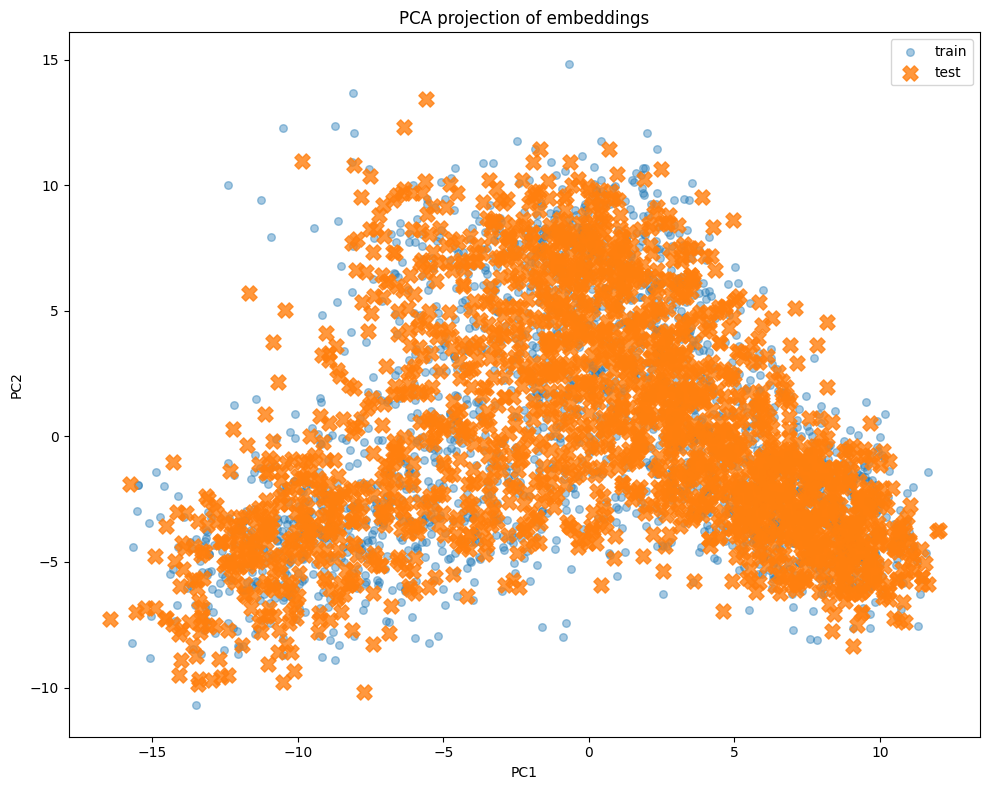

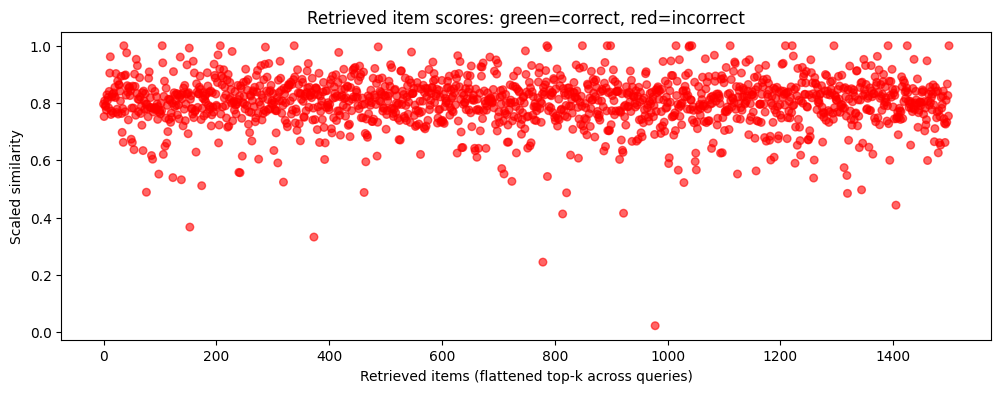

In [34]:
def plot_pca(train_embeddings, test_embeddings, sample_n=None):
    # Convert to numpy
    train_np = train_embeddings.cpu().numpy()
    test_np  = test_embeddings.cpu().numpy()
    # Optionally sample to speed up plotting
    if sample_n:
        if len(train_np) > sample_n:
            idx = np.random.choice(len(train_np), size=sample_n, replace=False)
            train_np = train_np[idx]
        if len(test_np) > sample_n:
            idx = np.random.choice(len(test_np), size=sample_n, replace=False)
            test_np = test_np[idx]
    all_emb = np.vstack([train_np, test_np])
    labels = np.array(['train'] * train_np.shape[0] + ['test'] * test_np.shape[0])
    scaler = StandardScaler()
    all_scaled = scaler.fit_transform(all_emb)
    pca = PCA(n_components=2)
    all_2d = pca.fit_transform(all_scaled)
    train_2d = all_2d[:train_np.shape[0]]
    test_2d  = all_2d[train_np.shape[0]:]

    plt.figure(figsize=(10, 8))
    plt.scatter(train_2d[:,0], train_2d[:,1], label='train', alpha=0.4, s=30)
    plt.scatter(test_2d[:,0], test_2d[:,1], label='test', alpha=0.8, marker='X', s=120)
    plt.title("PCA projection of embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_correctness(results, id2rec, top_k=5, sample_limit=1000):
    """
    Scatter retrieved items colored by correctness.
    We flatten all top-k retrieved items across queries and color by whether
    the retrieved item's labels intersect with the query labels.
    """
    scores = []
    correctness = []
    for res in results:
        qid = res["query_id"]
        q_labels = set(id2rec.get(qid, {}).get("labels", []))
        for rid, score in res["top_k"][:top_k]:
            r_labels = set(id2rec.get(rid, {}).get("labels", []))
            correct = 1 if len(q_labels.intersection(r_labels)) > 0 else 0
            scores.append(score)
            correctness.append(correct)
    if len(scores) == 0:
        print("No retrievals to visualize.")
        return
    scores = np.array(scores)
    correctness = np.array(correctness)
    # scale scores 0..1
    scaled = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    # optionally sample to avoid huge plots
    if len(scaled) > sample_limit:
        idx = np.random.choice(len(scaled), sample_limit, replace=False)
        scaled = scaled[idx]
        correctness = correctness[idx]
    colors = ['green' if c==1 else 'red' for c in correctness]
    plt.figure(figsize=(12,4))
    plt.scatter(range(len(scaled)), scaled, c=colors, alpha=0.6, s=30)
    plt.xlabel("Retrieved items (flattened top-k across queries)")
    plt.ylabel("Scaled similarity")
    plt.title("Retrieved item scores: green=correct, red=incorrect")
    plt.show()

# Plot PCA (small sample if very large)
plot_pca(train_embeddings, test_embeddings, sample_n=2000)  # change sample_n or None
visualize_correctness(miniLM_results, train_map, top_k=5, sample_limit=1500)

In [35]:
def preview_search_results(results, train_texts, test_texts, n=3):
    for i, res in enumerate(results[:n]):
        qid = res["query_id"]
        qidx = test_ids.index(qid)
        print(f"\n=== Query {i} (id={qid}) snippet ===")
        print(test_texts[qidx][:400], "...\n")
        for rid, score in res["top_k"]:
            try:
                tidx = train_ids.index(rid)
            except ValueError:
                tidx = None
            print(f"  -> Train id {rid} | score: {score:.4f}")
            if tidx is not None:
                print("     ", train_texts[tidx][:300], "...\n")
            else:
                print("     (train text not found)\n")

preview_search_results(miniLM_results, train_texts, test_texts, n=3)


=== Query 0 (id=100002997) snippet ===
2.Prosecution case in brief was that Tuliya Devi, daughter of informant Bhullu Rajbhar (PW-1) was married to Gullu 5 years ago. After marriage Tuliya Devi was treated with cruelty by her husband Gullu, father-in-law Bal Chand and mother-in-law Ramwati for demand of dowry. For this reason these three accused had committed murder of Tuliya Devi on 8.5.2010 by inflicting injuries on her body at their ...

  -> Train id 1889801 | score: 0.8676
      Mr. M. Karpaga Vinayagam, learned Amicus Curiae supported thejudgments of the High Court. The prosecution version as unfolded during trial is as follows: 3 In the night between August 30 and 31, 1994 at about 12.30 fivepersons of Sheo Pal's family were gunned down in his house in villageSaloni withi ...

  -> Train id 32097307 | score: 0.8544
      Perused the lower court's record. Prosecution case, which surfaced from record, was that an information by one Shrichand Bind, a representative of Gram Pradhan

In [39]:
from pinecone import Pinecone, ServerlessSpec
from tqdm import tqdm
import numpy as np
import torch
import os

# Initialize Pinecone
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY") or PINECONE_API_KEY)
index_name = "legal-minilm-embeddings"

# Create or connect
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)
print(f"✅ Connected to Pinecone index: {index_name}")

# --- Prepare vectors (truncate metadata) ---
def prepare_pinecone_vectors(ids, embeddings, texts, max_length=4000):
    vectors = []
    for i, emb in enumerate(embeddings):
        text = texts[i][:max_length]  # truncate text safely
        vectors.append({
            "id": str(ids[i]),
            "values": emb.tolist(),
            "metadata": {"data": text}
        })
    return vectors

# Prepare training data
train_texts = [" ".join(item["text"]) for item in train_data]
train_embeddings_np = train_embeddings.cpu().numpy()

train_vectors = prepare_pinecone_vectors(train_ids, train_embeddings_np, train_texts)

# Upload to Pinecone in batches
batch_size = 100
for i in tqdm(range(0, len(train_vectors), batch_size), desc="Uploading to Pinecone"):
    batch = train_vectors[i:i+batch_size]
    try:
        index.upsert(vectors=batch)
    except Exception as e:
        print(f"⚠️ Skipped batch {i//batch_size + 1}: {e}")

print(f"✅ Successfully uploaded {len(train_vectors)} training vectors to Pinecone!")


✅ Connected to Pinecone index: legal-minilm-embeddings


Uploading to Pinecone: 100%|██████████| 429/429 [02:25<00:00,  2.94it/s]

✅ Successfully uploaded 42835 training vectors to Pinecone!
